In [1]:
"""
Paul Hanakata 2020 
Physical Review Research 2 (4), 042006

Supervised Autoencoder 
This notebook perform: 
1) Training and prediction 
2) Interpolation 
3) Projection to latent space 
The basic implementation of VAE is adapted from https://github.com/aymericdamien/
"""

'AE CNN search with N steps'

In [2]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [3]:
alldata_15G=np.loadtxt('../mddata/15grid_all_1.92_shuffled.dat')

In [4]:
import sys 
sys.path.append("../tools/")
#module to handle mapping strings <-> arrays
from helper_functions import * 
#module to read and preprocess raw data
from preprocess import * 
from generate_lattice import * 
#from tf_regressor import * 


In [4]:
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
#paramters to make finer grids 
NCcell_x = 3
NCcell_y = 5
ncell_x = 34
ncell_y = 80

In [6]:
#create fine grids 
specificDensity=False
noCut=7

listFG=[]
if specificDensity:
    alldata_15Gs =[]
    for i in range (len(alldata_15G)):
        count =0
        for j in range (15):
            #count number of no-cut
            if alldata_15G[i][j]==1:
                count=count+1
        if count == noCut:
            alldata_15Gs.append(alldata_15G[i])
    
    alldata_15G = np.arrray(alldata_15Gs)


for i in range (len(alldata_15G)):
    cutConfigurations=alldata_15G[i, 0:-3]
    inner = generateInnerCell(NCcell_x, NCcell_y, ncell_x, ncell_y)
    inner_wCuts = makeCutsonCell(cutConfigurations, inner, NCcell_x, NCcell_y, ncell_x, ncell_y)
    listFG.append(inner_wCuts)

alldata_FG = np.array(listFG)
alldata_FG = np.append(alldata_FG, alldata_15G[:, -3:], 1)
#the last three columns are yield strain, toughness, and yield stress. 
#just ignore the toughness

#the rest are TF, I will use the 15grid as an example here 
#alldata = alldata_15G
alldata = alldata_FG #unflag this for fine grid

nfeatures = len(alldata[0])-3 #nfeautures is needed later to split the matrix
print("Number of data:", len(alldata))
print("Number of features (or inputs/grids):", nfeatures)


#DON't shuffle, data is already pre-shuffled to make sure we have same test set for all models 
#np.random.shuffle(alldata)
x, y=create_matrix(alldata, False, 0, 0.375, nfeatures)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(x, y, 0.5, 0.25)


x, y=create_matrix(alldata, False, 2, 0.375, nfeatures)
#1 is STRAIN, 2 is STRESS not TOUGHNESS
X_train, X_valid, X_test, y_train2, y_valid2, y_test2 = split_data(x, y, 0.5, 0.25)


print (len(y_valid), len(y_test))


y_train = np.reshape(y_train, (len(y_train), 1))
y_valid = np.reshape(y_valid, (len(y_valid), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

y_train2 = np.reshape(y_train2, (len(y_train2), 1))
y_valid2 = np.reshape(y_valid2, (len(y_valid2), 1))
y_test2 = np.reshape(y_test2, (len(y_test2), 1))


Number of data: 62558
Number of features (or inputs/grids): 2400
Number of good designs 479 out of total 62558
Number of good designs 62558 out of total 62558
15639 15640


## Rescale data 

In [8]:
#y_train_all = np.append(y_train, np.log(y_train2), 1)
y_train_all = np.append(np.log(y_train), np.log(y_train2), 1)
std1 = np.std(y_train_all[:, 0])
std2 = np.std(y_train_all[:, 1])
mean1 = np.mean(y_train_all[:, 0])
mean2 = np.mean(y_train_all[:, 1])

#resclae train 
y_train_all[:, 0] = (y_train_all[:, 0]-mean1)/std1
y_train_all[:, 1] = (y_train_all[:, 1]-mean2)/std2

#rescale valid
y_valid_all = np.append(np.log(y_valid), np.log(y_valid2), 1)
y_valid_all[:, 0] = (y_valid_all[:, 0]-mean1)/std1
y_valid_all[:, 1] = (y_valid_all[:, 1]-mean2)/std2

y_test_all = np.append(np.log(y_test), np.log(y_test2), 1)
y_test_all[:, 0] = (y_test_all[:, 0]-mean1)/std1
y_test_all[:, 1] = (y_test_all[:, 1]-mean2)/std2



## CNN model 

In [52]:
# Convolutional Layer 1.
filter_size1 = 3         # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 3      # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.

filter_size3 = 3      # Convolution filters are 5 x 5 pixels.
num_filters3 = 64       # There are 36 of these filters.


# Fully-connected layer.
fc_size1 = 128
fc_size2 = 64 # Number of neurons in fully-connected layer.

In [53]:
# We know that MNIST images are 28 pixels in each dimension.
img_size1 = 30
img_size2 = 80

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size1 * img_size2

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size1, img_size2)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
# Number of classes, one class for each of 10 digits.
#num_classes = 2

In [54]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [55]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)


    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

   
    layer += biases

    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    
    layer = tf.nn.relu(layer)

  
    return layer, weights, biases


In [13]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

  
    return layer_flat, num_features



In [56]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

   
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

   
    layer = tf.matmul(input, weights) + biases

  
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer, weights, biases

In [57]:
def reuse_fc_layer(input, 
                   num_inputs, 
                   num_outputs, 
                   weights, 
                   biases, 
                   use_relu=True): 
   
    layer = tf.matmul(input, weights) + biases

   
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [58]:
# Parameters
learning_rate = 0.0001# 0.001
training_epochs = 50 # 300 (max ephocs)
batch_size = 128 #200 
dropout_rate = 0 #0.0
display_step = 10 

In [59]:
# FCL Network Parameters
image_dim = 2400 # MNIST images are 28x28 pixels
fc_size1 = 512
fc_size2= 128
hidden_dim1 = 512 #fc_size2
hidden_dim2 = 1024#fc_size1 
latent_dim = 8
y_dim = 2

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1.5/ tf.sqrt(shape[0] / 2.))

In [60]:
# Variables
weights = {}
biases = {}

In [62]:
def encoder_conv_net(x):
    x_image = tf.reshape(x, [-1, img_size1, img_size2, num_channels])
    layer_conv1, weights_conv1, biases_conv1 = \
        new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    layer_conv2, weights_conv2, biases_conv2 = \
        new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
    
    layer_conv3, weights_conv3, biases_conv3 = \
        new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
    
    
    layer_flat, num_features = flatten_layer(layer_conv3)

    layer_fc1, weights_fc1, biases_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)
    
    layer_fc2 , weights_fc2, biases_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True)
    
    
    
    
    layer_fc3 , weights_fc3, biases_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size2,
                         num_outputs=latent_dim+y_dim,
                         use_relu=False)
    
    weights['w_c1']=weights_conv1
    weights['w_c2']=weights_conv2
    weights['w_c3']=weights_conv3
    weights['w_fc1']=weights_fc1
    weights['w_fc2']=weights_fc2
    weights['w_fc3']=weights_fc3
    
    biases['b_c1']=biases_conv1
    biases['b_c2']=biases_conv2
    biases['b_c3']=biases_conv3
    biases['b_fc1']=biases_fc1
    biases['b_fc2']=biases_fc2
    biases['b_fc3']=biases_fc3

    

    zz = layer_fc3
    return zz, layer_conv1, weights_conv1, layer_conv2, weights_conv2

In [63]:
# Variables
weightsx = {
    'decoder_h1': tf.Variable(glorot_init([latent_dim+y_dim, hidden_dim1])),
    'decoder_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim2, image_dim]))
}
biasesx = {
    'decoder_b1': tf.Variable(glorot_init([hidden_dim1])),
    'decoder_b2': tf.Variable(glorot_init([hidden_dim2])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [64]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
y_true = tf.placeholder(tf.float32, shape=[None, y_dim])

z_mean, layer_conv1, weights_conv1, layer_conv2, weights_conv2  = encoder_conv_net(input_image)

z = z_mean 

decoder = tf.matmul(z, weightsx['decoder_h1']) + biasesx['decoder_b1']
decoder = tf.nn.relu(decoder)
decoder = tf.matmul(decoder, weightsx['decoder_h2']) + biasesx['decoder_b2']
decoder = tf.nn.relu(decoder)
decoder = tf.matmul(decoder, weightsx['decoder_out']) + biasesx['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [65]:
# Define construction Loss
def cons_loss(x_reconstructed, x_true):

    encode_decode_loss = tf.reduce_mean(tf.pow(x_reconstructed-x_true, 2))

    return encode_decode_loss

# Define latent space losss
def y_loss(z, y_true):
   
    encode_loss1 = tf.reduce_mean(tf.pow(z[:, 0]-y_true[:, 0], 2))
    encode_loss2 = tf.reduce_mean(tf.pow(z[:, 1]-y_true[:, 1], 2))
 
   
    return encode_loss1+encode_loss2

loss1 = cons_loss(decoder, input_image)
loss2 = y_loss(z, y_true)

#supervised
loss_op = tf.reduce_mean(loss1+1.0*loss2)
#unsupervised
#loss_op = tf.reduce_mean(loss1)

#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                            #epsilon=.001)
#.minimize(loss)
train_op = optimizer.minimize(loss_op)
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

## Training 

In [66]:
### Start Training
# Start a new TF session
sess = tf.Session()
# Run the initializer
sess.run(init)

n_total = len(X_train)
total_batches = int(n_total/batch_size)
epochs = 80
num_steps = epochs * total_batches
print(num_steps)
# Training
for i in range(1, num_steps+1):
    j = i % total_batches
    batch_x = X_train[batch_size*(j-1):batch_size*j] 
    batch_y = y_train_all[batch_size*(j-1):batch_size*j, :y_dim] 
    #batch_y = y_train[batch_size*(j-1):batch_size*j] 
    # Train
    feed_dict = {input_image: batch_x, y_true: batch_y}
    _, l, l1, l2 = sess.run([train_op, loss_op, loss1, loss2], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f %f %f' % (i, l, l1, l2))


19520
Step 1, Loss: 2.947645 0.261160 2.686484
Step 1000, Loss: 0.433185 0.057849 0.375336
Step 2000, Loss: 0.251595 0.034177 0.217417
Step 3000, Loss: 0.399586 0.028132 0.371454
Step 4000, Loss: 0.149503 0.028659 0.120845
Step 5000, Loss: 0.147056 0.024994 0.122061
Step 6000, Loss: 0.136229 0.021156 0.115074
Step 7000, Loss: 0.149554 0.017632 0.131921
Step 8000, Loss: 0.125496 0.015982 0.109514
Step 9000, Loss: 0.128090 0.012782 0.115308
Step 10000, Loss: 0.128638 0.010226 0.118411
Step 11000, Loss: 0.090932 0.008912 0.082020
Step 12000, Loss: 0.139294 0.007049 0.132244
Step 13000, Loss: 0.088057 0.007001 0.081056
Step 14000, Loss: 0.090302 0.005272 0.085030
Step 15000, Loss: 0.098212 0.003716 0.094496
Step 16000, Loss: 0.160913 0.005016 0.155896
Step 17000, Loss: 0.056114 0.002222 0.053892
Step 18000, Loss: 0.062902 0.001869 0.061032
Step 19000, Loss: 0.050753 0.002646 0.048106


## Histogram for mechanical properties and latent variables 

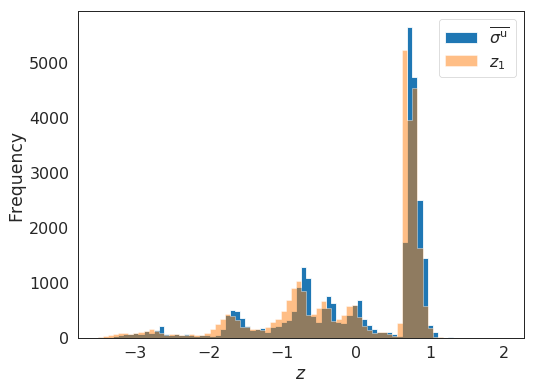

In [42]:
#plt.hist(y_train_all[:, 0], bins=100, alpha=0.4, range=(-3, 8),  label='true strain')
dataset='train'
fig=plt.figure(figsize=(8, 6)) 

sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.5})
sns.set_style("white",{'axes.grid': False,'grid.linestyle': '--',  'axes.linewidth': 1.0,})

k=1
if k==0:
    prop="strain"
    plt.hist(y_train_all[:, 0], bins=100, histtype='stepfilled', range=(-5, 10), alpha=1,  label=r'$\overline{\epsilon^{\rm u}}$')
    plt.hist(z_mu[:, 0], bins=100, histtype='stepfilled', alpha=0.5, range=(-5, 10), label=r'$z_0$')
else:
    prop="stress"
    plt.hist(y_train_all[:, 1], bins=80, histtype='stepfilled', range=(-3.5, 2), alpha=1,  label=r'$\overline{\sigma^{\rm u}}$')
    plt.hist(z_mu[:, 1], bins=80, histtype='stepfilled', alpha=0.5, range=(-3.5, 2), label=r'$z_1$')
    


plt.xlabel(r'$z$')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
#plt.show()
pngtext="hist-"+dataset+"-"+prop+".png"
#pngtext="qplot-"+dataset+"-"+str(k)+".png"
plt.savefig(pngtext)
#plt.show()
#pp.savefig(fig) 
#pp.close()

## Histogram of latent variables

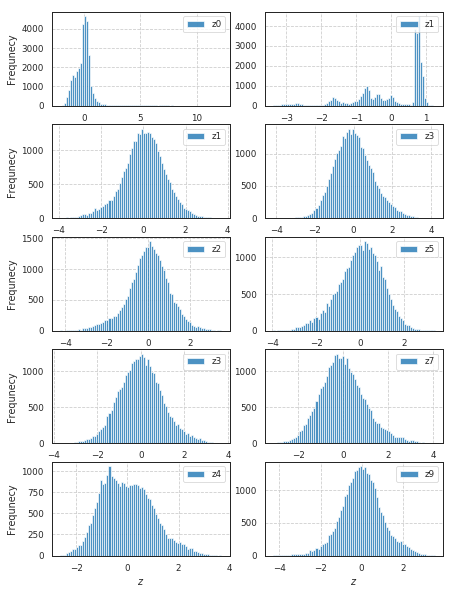

In [87]:
sns.set_context("paper", font_scale=1., rc={"lines.linewidth": 1.5})
fig = plt.figure(figsize=(7, 10))
#fig.subplots_adjust(hspace=0.1, wspace=.1)
count = 0 
n=5
for j in range (n):
    #print(i)
    count = count + 1
    plt.subplot(n, 2, count)
    #plt.subplot(221)
    
    plt.hist((z_mu[:, j*2]-np.mean(z_mu[:, j*2]))/np.std(z_mu[:, j*2]), alpha=0.8, bins=80, label='z'+str(j))
    plt.xlabel(r'$z$')
    plt.ylabel('Frequnecy')
    plt.legend(loc='upper right')
    
    #plt.imshow(batch_x[i].reshape([h, w]))
    #plt.axis('off')
    
    #plt.subplot(222)
    count = count +1
    plt.subplot(n, 2, count)
     
    plt.hist((z_mu[:, j*2+1]-np.mean(z_mu[:, j*2+1]))/np.std(z_mu[:, j*2+1]), alpha=0.8, bins=80, label='z'+str(j*2+1))
    plt.xlabel(r'$z$')
    #plt.ylabel('Frequnecy')
    plt.legend(loc='upper right')
     
    #plt.imshow(np.round(x_mean[i]).reshape([h, w]))
    #plt.axis('off')
    
plt.show()

## Accuracy on mechanical properties  (R^2)

In [206]:

from sklearn.metrics import r2_score

datasets = ['train', 'valid', 'test']

for dataset in datasets:
    
    if dataset=='train':
        x_sample =X_train
        y_sample =y_train_all[:, :y_dim]
    elif dataset=='valid':
        x_sample =X_valid
        y_sample =y_valid_all[:, :y_dim]
    else: 
        x_sample =X_test
        y_sample =y_test_all[:, :y_dim]

    feed_dict = {input_image: x_sample, y_true: y_sample}
    z_mu = sess.run(z,feed_dict=feed_dict)
    
    #print (z_mu.shape)
    #if valid:
    if dataset =='train':
        #print (z_mu.shape)
        print("R2 Train:", r2_score(y_train_all[:, 0], z_mu[:, 0]), r2_score(y_train_all[:, 1], z_mu[:, 1]),np.average((y_train_all[:, 0]-z_mu[:, 0])**2),np.average((y_train_all[:, 1]-z_mu[:, 1])**2))
    elif dataset =='valid':
        print("R2 Valid:", r2_score(y_valid_all[:, 0], z_mu[:, 0]), r2_score(y_valid_all[:, 1], z_mu[:, 1]),np.average((y_valid_all[:, 0]-z_mu[:, 0])**2),np.average((y_valid_all[:, 1]-z_mu[:, 1])**2))
    else:
        print("R2 Test:", r2_score(y_test_all[:, 0], z_mu[:, 0]), r2_score(y_test_all[:, 1], z_mu[:, 1]),np.average((y_test_all[:, 0]-z_mu[:, 0])**2),np.average((y_test_all[:, 1]-z_mu[:, 1])**2))

R2 Train: 0.9362975030575883 0.9951007892178809 0.06370249694241173 0.004899210782119092
R2 Valid: 0.8744140066122338 0.9940055944166243 0.12272337538592308 0.0059766583158776445
R2 Test: 0.8652868628020731 0.9940836783684864 0.13212913503470158 0.005941812311305818


##  Accuracy score on reconstruction 

In [207]:
#valid=True
from sklearn.metrics import r2_score, accuracy_score

datasets = ['train', 'valid', 'test']

for dataset in datasets:
    
    if dataset=='train':
        x_sample =X_train
        y_sample =y_train_all[:, :y_dim]
    elif dataset=='valid':
        x_sample =X_valid
        y_sample =y_valid_all[:, :y_dim]
    else: 
        x_sample =X_test
        y_sample =y_test_all[:, :y_dim]

    #feed_dict = {input_image: x_sample, y_true: y_sample}
    #z_mu = sess.run(z,feed_dict=feed_dict)
    
    
    feed_dict = {input_image: x_sample, y_true:y_sample[:, :y_dim]}
    x_mean = sess.run(decoder, feed_dict=feed_dict)
    
    
        
    if dataset =='train':
        ave = 0 
        for ii in range(len(X_train)):
            ave = ave + accuracy_score(X_train[ii], np.round(x_mean[ii]))
        print("R2 Train:", ave/len(X_train))
    elif dataset =='valid':
        ave = 0 
        for ii in range(len(X_valid)):
            ave = ave + accuracy_score(X_valid[ii], np.round(x_mean[ii]))
        print("R2 valid:", ave/len(X_valid))
        
        #print("R2 Valid:", accuracy_score(X_valid, np.round(x_mean)))
    else:
        ave = 0 
        for ii in range(len(X_test)):
            ave = ave + accuracy_score(X_test[ii], np.round(x_mean[ii]))
        print("R2 test:", ave/len(X_test))
        
        
        #print("R2 Test:", accuracy_score(X_test, np.round((x_mean)))) 
    

R2 Train: 0.9993063636945166
R2 valid: 0.9988779387002673
R2 test: 0.9987652387041885


## Regression plot 

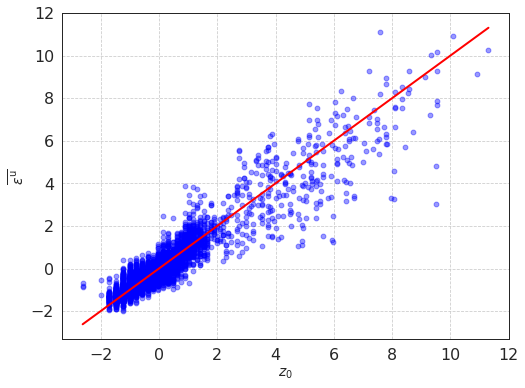

In [35]:
k=0
dataset = 'test'

pp = PdfPages('qplot-'+dataset+'-'+str(k)+'.pdf')
#sns.set_context("paper", font_scale=2, rc={"lines.linewidth": .5})
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.5})
sns.set_style("white",{'axes.grid': True,'grid.linestyle': '--',  'axes.linewidth': 1.0,})
#sns.set_style("white",{'axes.grid': True,'grid.linestyle': '--',  'axes.linewidth': 1.0,})

#fig, axes =plt.subplots(2, 1, sharey='row')
fig=plt.figure(figsize=(8, 6)) 



if dataset=='train':
    x_sample =X_train
    y_sample =y_train_all[:, :y_dim]
elif dataset=='valid':
    x_sample =X_valid
    y_sample =y_valid_all[:, :y_dim]
else: 
    x_sample =X_test
    y_sample =y_test_all[:, :y_dim]

feed_dict = {input_image: x_sample, y_true: y_sample}
z_mu = sess.run(z,feed_dict=feed_dict)


if dataset =='train':
    plt.plot(y_train_all[:, k], z_mu[:, k], 'bo', alpha=0.4)
    ysorted = np.sort(y_train_all[:, k])
elif dataset =='valid':
    #plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_valid_all[:, 0], cmap=plt.cm.Spectral, s=10) #CMRmap
    plt.plot(y_valid_all[:, k], z_mu[:, k], 'bo', alpha=0.4)
    ysorted = np.sort(y_valid_all[:, k])
else:
    plt.plot(y_test_all[:, k], z_mu[:, k], 'bo', alpha=0.4)
    ysorted = np.sort(y_train_all[:, k])


xx = np.linspace(ysorted[0], ysorted[-1], len(ysorted))
plt.plot(xx, xx, 'r', linewidth=2)
if k==0:
    plt.xlabel(r'$z_0$', fontsize=14)
    plt.ylabel(r'$\overline{\epsilon^{\rm u}}$', fontsize=14)
else:
    plt.xlabel(r'$z_1$', fontsize=14)
    plt.ylabel(r'$\overline{\sigma^{\rm u}}$', fontsize=14)
    
pngtext="qplot-"+dataset+"-"+str(k)+".png"
plt.savefig(pngtext)
#plt.show()
pp.savefig(fig) 
pp.close()


#plt.xlim([-2.5, 15])
#plt.ylim([-2.5, 15])

## Interpolation in latent space 

In [93]:
dataTrain = np.append(X_train, y_train_all, 1)
dataTrain = dataTrain[dataTrain[:, -2].argsort()]

In [30]:
npairs=10
np.random.seed(100)
arrpairs = np.random.randint(len(X_train), size=(npairs, 2))
top=False
if top:
    for i in range(len(arrpairs)//2):
        arrpairs[i, 0] = np.random.randint(100)
    for i in range(len(arrpairs)//2, len(arrpairs)):        arrpairs[i, 0] =-np.random.randint(100)

In [ ]:
"USE this for N interpolation"

In [100]:

## use this for 1 top/top, 1 bottom/bottom, 4 random/top, 4random/bottom
npairs=10
np.random.seed(200)
arrpairs = np.random.randint(len(X_train), size=(npairs, 2))
#first top strain 
arrpairs[0, 0] =-np.random.randint(1000)
arrpairs[0, 1] =-np.random.randint(1000)

#
arrpairs[1, 0] =np.random.randint(1000)
arrpairs[1, 1] =np.random.randint(1000)

for i in range(2, 6):
    arrpairs[i, 0] = -np.random.randint(1000)
for i in range(6, 10):
    arrpairs[i, 0] = np.random.randint(1000)    
    
#for i in range(len(arrpairs)//2, len(arrpairs)):
#        arrpairs[i, 0] =-np.random.randint(100)





In [37]:
index = [23000, -100]
#index = [-300, -200]
#x_sample =X_train
#index1=-10
nsample = 2 
x_sample = np.zeros((nsample, 2400))
y_sample = np.zeros((nsample, 2))

for i in range(len(index)):
    #x_sample[i, :]
    x_sample[i, :] = dataTrain[index[i], :-2]
    y_sample[i, :] = dataTrain[index[i], :y_dim]



#y_sample = y_sample
print(x_sample.shape, y_sample.shape)
#X_train[int(j*batch_size):int((k)*batch_size)]
#y_sample =y_train[int(j*batch_size):int((k)*batch_size)]

feed_dict = {input_image: x_sample, y_true: y_sample}

z_samp = sess.run(z,feed_dict=feed_dict)
#z_mu = vae_2d.transform(x_sample)
#plt.figure(figsize=(12,  12)) 

(2, 2400) (2, 2)


In [ ]:
"Use this for N=20 interpolation"

In [101]:

nsample = npairs*2
x_sample = np.zeros((nsample, 2400))
y_sample = np.zeros((nsample, 2))

for n in range (len(arrpairs)):
    for pair in range(len(arrpairs[n])):
        #x_sample[i, :]
        x_sample[n*2+pair, :] = dataTrain[arrpairs[n, pair], :-2]
        y_sample[n*2+pair, :] = dataTrain[arrpairs[n, pair], :y_dim]



#y_sample = y_sample
print(x_sample.shape, y_sample.shape)
#X_train[int(j*batch_size):int((k)*batch_size)]
#y_sample =y_train[int(j*batch_size):int((k)*batch_size)]

feed_dict = {input_image: x_sample, y_true: y_sample}

z_samp = sess.run(z,feed_dict=feed_dict)
#z_mu = vae_2d.transform(x_sample)
#plt.figure(figsize=(12,  12)) 

(20, 2400) (20, 2)


In [79]:
from numpy import linalg as LA


In [102]:
Ninterp=20
znew =np.zeros((Ninterp*npairs, latent_dim+y_dim))
j=0
for npair in range (0, len(z_samp), 2):
   # print (npair, npair+1)
    z1= z_samp[npair]
    z2= z_samp[npair+1]
    z1n = LA.norm(z1)
    z2n = LA.norm(z2)
    dot = np.sum(z1*z2)/z1n/z2n
    omega=np.arccos(dot)
    #print(omega/2/np.pi*360)
    
    for i in range(0, Ninterp):
        #print (i+1)
        f = (i+1)/(Ninterp+1)
        #print(f)
        #zslerp = (1-f)*z1+f*z2
        zslerp=(np.sin((1-f)*omega)/np.sin(omega)*z1+np.sin(f*omega)/np.sin(omega)*z2)
        znew[j, :] = zslerp
        j= j+1
        #print (i)
    #znew, z1, z2

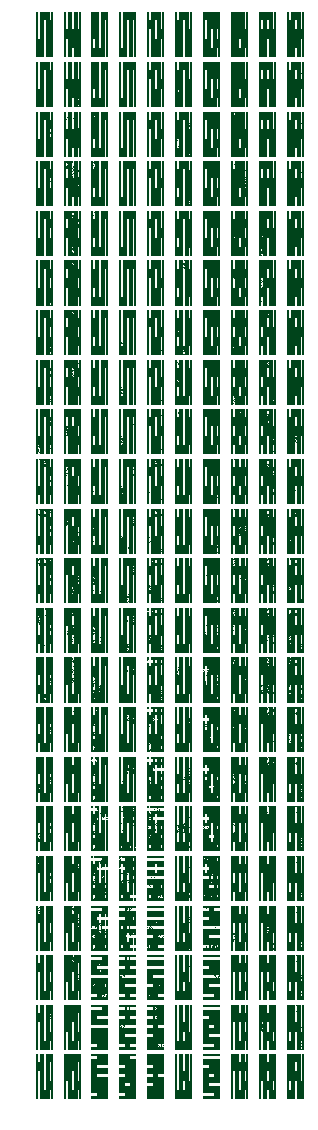

In [127]:
#znew =znew.reshape((1,10))
h=30
w=80
z_input = tf.placeholder(tf.float32, shape=[None, latent_dim+y_dim])
decoder2 = tf.matmul(z_input, weightsx['decoder_h1']) + biasesx['decoder_b1']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_h2']) + biasesx['decoder_b2']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_out']) + biasesx['decoder_out']
decoder2 = tf.nn.sigmoid(decoder2)
decoder2 = tf.round(decoder2)


nn = 1

z_train = znew
x_mean = sess.run(decoder2, feed_dict={z_input:z_train})

fig = plt.figure(figsize=(5, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.01)
count=0

Ninterp=20
nrow = Ninterp+2
ncolumn = npairs
ntotal=nrow*ncolumn
count = 0
npairr=0
for npair in range (len(arrpairs)):
    index =[arrpairs[npair, 0], arrpairs[npair, 1]]
    count = count + 1
    plt.subplot(nrow, ncolumn, count)
    plt.imshow(np.rot90(dataTrain[index[0], :-2].reshape([30, 80])), cmap='Greens')
    plt.axis('off')

arrayValues = np.zeros((Ninterp, npairs*2))

listLatent = []
listValues = []
for it in range(0, Ninterp):
    for npair in range (len(arrpairs)):
        #print(npair)
        index =[arrpairs[npair, 0], arrpairs[npair, 1]]
        #count = count + 1
        #plt.subplot(nrow, ncolumn, count)
        #plt.imshow(dataTrain[index[0], :-2].reshape([30, 80]))
        #plt.axis('off')
        i = npair*Ninterp+it
        
        z1= z_samp[npair*2]
        z2= z_samp[npair*2+1]
    
        count = count+1 
        plt.subplot(nrow, ncolumn, count)
    
    
        jc1 = np.sum (dataTrain[index[0], :-2]*x_mean[i])/(
            (LA.norm(dataTrain[index[0], :-2]))**2+(LA.norm(x_mean[i]))**2-np.sum(dataTrain[index[0], :-2]*x_mean[i]))
    
        jc2 = np.sum (dataTrain[index[1], :-2]*x_mean[i])/(
            (LA.norm(dataTrain[index[1], :-2]))**2+(LA.norm(x_mean[i]))**2-np.sum(dataTrain[index[1], :-2]*x_mean[i]))
    
        
        arrayValues[it,npair*2]=znew[i, 0]
        arrayValues[it,npair*2+1]=znew[i, 1]
                                  
        plt.imshow(np.rot90(x_mean[i].reshape([h, w])), cmap='Greens')
    
        d1 = np.sqrt(np.sum((z1-znew[i])**2))
        d2=  np.sqrt(np.sum((z2-znew[i])**2))
        d = np.sqrt(np.sum((z1-z2)**2))
    
        z1n = LA.norm(z1)
        z2n = LA.norm(z2)
        zz = LA.norm (znew[i])
    
    
        dot1 = np.sum(z1*znew[i])/z1n/zz
        omega1=np.arccos(dot1)/2/np.pi*360
        dot2 = np.sum(z2*znew[i])/z2n/zz
        omega2=np.arccos(dot2)/2/np.pi*360
        dot = np.sum(z1*z2)/z1n/z2n
        omega=np.arccos(dot)/2/np.pi*360
        if npair==9:
            listLatent.append([it+1, d1/d, d2/d, omega1/omega, omega2/omega, jc1, jc2, (jc1+jc2)/2, omega1+omega2, (d1+d2)/d])

        plt.axis('off')
   
    npairr=npairr+1

for npair in range (len(arrpairs)):
    index =[arrpairs[npair, 0], arrpairs[npair, 1]]
    count = count + 1
    plt.subplot(nrow, ncolumn, count)
    plt.imshow(np.rot90(dataTrain[index[1], :-2].reshape([h, w])), cmap='Greens')
    plt.axis('off')

plt.savefig("design-SLERP_l20_05.21_200.png")
plt.show()
    


In [50]:
z_samp.shape

(20, 10)

In [105]:
#print(x_mean.shape) 
np.save('configurations_slerp_05.10_200', x_mean)
np.save('z_samp_05.10_200', z_samp)
np.save('z_slerp_05.10_200', znew)


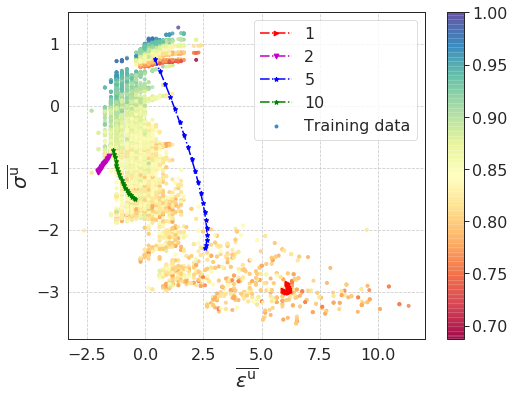

In [104]:
plt.figure(figsize=(8, 6)) 

log=True
if log:
    plt.scatter(y_train_all[:, 0], y_train_all[:, 1], c=yy, cmap=plt.cm.Spectral, s=10, alpha=0.8, label='Training data')
    plt.colorbar
    k=0
    plt.plot((arrayValues[:,k*2]), (arrayValues[:, k*2+1]), '>-.', color='r', label=k+1)

    
    k=1
    plt.plot((arrayValues[:,k*2]), (arrayValues[:, k*2+1]), 'v-.', color='m', label=k+1)
        
    k=4
    plt.plot((arrayValues[:,k*2]), (arrayValues[:, k*2+1]), '*-.', color='b', label=k+1)
    
    k=9
    plt.plot((arrayValues[:,k*2]), (arrayValues[:, k*2+1]), '*-.', color='g', label=k+1)
    
    plt.colorbar()
    
    plt.legend(loc='upper right')
    plt.xlabel(r'$\overline{\epsilon^{\rm u}}$', fontsize=20)
    plt.ylabel(r'$\overline{\sigma^{\rm u}}$', fontsize=20)
    
plt.savefig("design-SLERP_path_05.10_200.png")


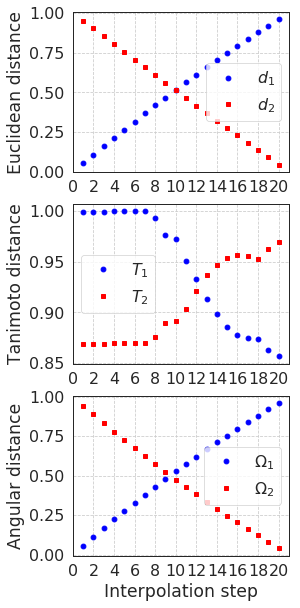

In [128]:
junk = np.array(listLatent)
k=9
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.5})
sns.set_style("white",{'axes.grid': True,'grid.linestyle': '--',  'axes.linewidth': 1.0,})
pp = PdfPages('distance-c'+str(k)+'.pdf')


fig = plt.figure(figsize=(5, 10))

fig.subplots_adjust(left=0.3, hspace=0.2, wspace=.5)
count=1
n=3
plt.subplot(n, 1, 1)
plt.plot(junk[:, 0], junk[:, 1],  'bo')
plt.plot(junk[:, 0], junk[:, 2],  'rs')
         #junk[:,2], 'ro')
#plt.plot(junk[:, 0], junk[:,7], 'ro')
plt.legend([r'$d_1$', r'$d_2$'])
#plt.xlabel('Interpolation step')
plt.ylabel('Euclidean distance')
plt.xlim([0, 21])
step = np.arange(0, 22, 2)
plt.xticks(step)

plt.subplot(n, 1, 2)
plt.plot(junk[:, 0], junk[:, 5],'bo') 
plt.plot(junk[:, 0], junk[:,6], 'rs')
#plt.plot(junk[:, 0], junk[:,7], 'ro')
plt.legend([r'$T_1$', r'$T_2$'])
#plt.xlabel('Interpolation step')
plt.ylabel('Tanimoto distance')
plt.xlim([0, 21])
step = np.arange(0, 22, 2)
plt.xticks(step)


plt.subplot (n, 1, 3)
plt.plot(junk[:, 0], junk[:, 3],  'bo')
plt.plot(junk[:, 0], junk[:, 4],  'rs')
#plt.plot(junk[:, 0], junk[:,7], 'ro')
plt.legend([r'$\Omega_1$', r'$\Omega_2$'])
plt.xlabel('Interpolation step')
plt.ylabel('Angular distance')
plt.xlim([0, 21])
step = np.arange(0, 22, 2)
plt.xticks(step)
plt.savefig("distance-c"+str(k)+".png")

pp.savefig(fig) 
pp.close()

plt.show()


In [88]:
data_z = []
for j in range (latent_dim+y_dim):
    data_z.append([np.mean(z_mu[:, j]), np.std(z_mu[:, j])])
print (data_z)

[[-0.031888377, 0.9721167], [-0.05168068, 1.0262108], [0.15423794, 0.64104503], [0.10186068, 0.5308088], [-0.3916634, 0.5916242], [0.035855938, 0.6031109], [0.034968846, 0.62273914], [0.3377147, 0.6582838], [0.32109874, 0.6963359], [-0.40600443, 0.64548826]]


## Reconstruction using decoder on train, valid, or test set

In [38]:
h=30
w=80
j = 1
batch_x =X_test[int(j*batch_size):int((j+1)*batch_size)]
batch_y =y_test_all[int(j*batch_size):int((j+1)*batch_size)]

#decoder = tf.round((decoder))
#Train
feed_dict = {input_image: batch_x, y_true:batch_y[:, :y_dim]}
x_mean = sess.run(decoder, feed_dict=feed_dict)

In [ ]:
h=30
w=80
j = 1
#batch_x =X_valid[int(j*batch_size):int((j+1)*batch_size)]
batch_x =X_test[int(j*batch_size):int((j+1)*batch_size)]
batch_y =y_test_all[int(j*batch_size):int((j+1)*batch_size)]

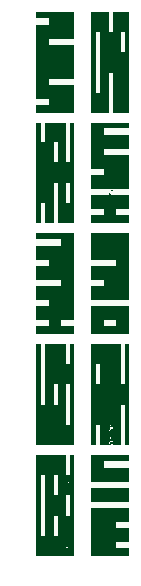

In [40]:
fig = plt.figure(figsize=(2, 10))

#fig =plt.figsize((2, 10))
fig.subplots_adjust(hspace=0.1, wspace=0)
count = 0 
n=10
cm='Greens'
test=True
for i in range (n):
    #print(i)
    if not test:
        count = count + 1
        plt.subplot(n/2, 2, count)
        #plt.subplot(221)
        xx = batch_x[i].reshape([h, w])
        xx = np.rot90(xx)

    
        plt.imshow(xx, cmap=cm)
        plt.axis('off')
    else:
        count = count +1
        plt.subplot(n/2, 2, count)
        xx2 = np.round(x_mean[i]).reshape([h, w])
        xx2 = np.rot90(xx2)
    
        plt.imshow(xx2, cmap=cm)
        plt.axis('off')
    
plt.show()

In [10]:
#y_train_all
#y_train_all = np.append(y_train, np.log(y_train2), 1)
y_train_all = np.append(y_train, y_train2, 1)
y_valid_all = np.append(y_valid, y_valid2, 1)
y_test_all = np.append(y_test, y_test2, 1)

y_train_all = np.concatenate((y_train_all, y_valid_all), axis=0)
y_train_all = np.concatenate((y_train_all, y_test_all), axis=0)

X_train = np.concatenate((X_train, X_valid), axis=0)
X_train = np.concatenate((X_train, X_test), axis=0)

## Visualize *ALL* data points

no


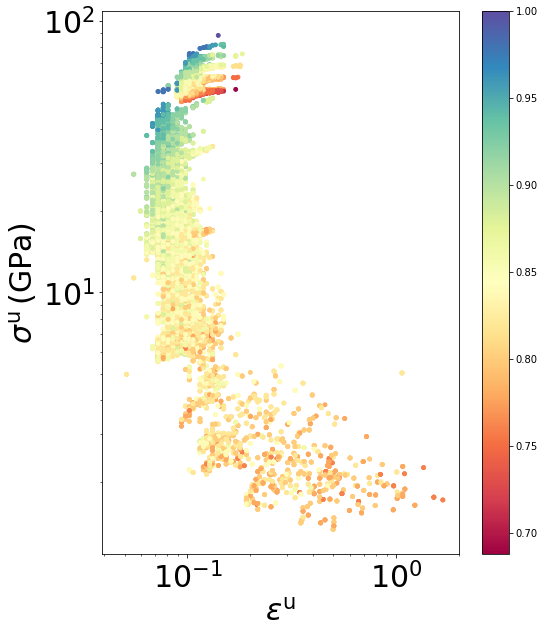

In [20]:
j = 0
k = 1
valid = False
dataset = 'valid'

#sns.set_style("darkgrid")
#sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.5})
#sns.set_style("white",{'axes.grid': True,'grid.linestyle': '--',  'axes.linewidth': 2.0,})

if valid:
    y_valid_all = np.append(np.log(y_valid), np.log(y_valid2), 1)
    y_train_all2 = np.append(np.log(y_train), np.log(y_train2), 1)
    #y_train_all2 = np.append(y_train, y_train2, 1)

    std1 = np.std(y_train_all2[:, 0])
    std2 = np.std(y_train_all2[:, 1])
    y_valid_all[:, 0] = (y_valid_all[:, 0]-np.mean(y_train_all2[:, 0]))/std1
    y_valid_all[:, 1] = (y_valid_all[:, 1]-np.mean(y_train_all2[:, 1]))/std2
         
    x_sample =X_valid
    y_sample =y_valid_all[:, :y_dim]


else: 
    print("no")
    #x_sample =X_train
    #y_sample =y_train_all[:, :y_dim]


plt.figure(figsize=(8, 10)) 
if valid: 
    yy = np.sum(X_valid, axis=1)/2400
    plt.scatter(z_mu[:, 0], z_mu[:,1], c=yy, cmap=plt.cm.Spectral, s=15) #CMRmap
    
else:
    yy = np.sum(X_train, axis=1)/2400
    #plt.scatter(z_mu[:, 0], z_mu[:,1], c=yy, cmap=plt.cm.Spectral, s=15) 
    plt.scatter(y_train_all[:, 0], y_train_all[:,1], c=yy, cmap=plt.cm.Spectral, s=15) #CMR

plt.xscale('log')
plt.yscale('log')

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.xlabel(r'$\overline{\epsilon^{\rm u}}$', fontsize=20)
#plt.ylabel(r'$\overline{\sigma^{\rm u}}$', fontsize=20)
plt.xlabel(r'$\epsilon^{\rm u}$', fontsize=30)
plt.ylabel(r'$\sigma^{\rm u}\,{\rm  (GPa)}$', fontsize=30)



plt.colorbar()
#plt.grid(which='both')
plt.savefig('stress-strain-all-noGrid.png')
plt.show()

## Projection to latent space 

In [47]:
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA


In [49]:
#pca = RandomizedPCA(n_components=2)
pca = PCA(n_components=2, svd_solver = 'randomized')


In [50]:
X_transformed = pca.fit_transform(z_mu)

#X_transformed = pca.fit_transform(X_train)



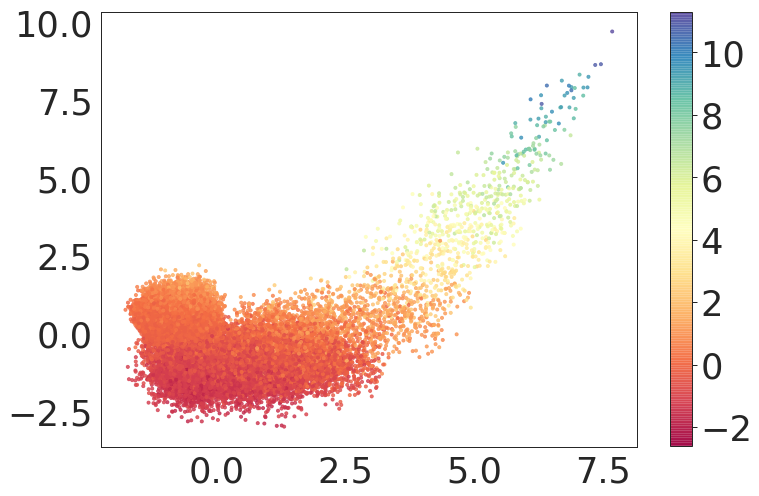

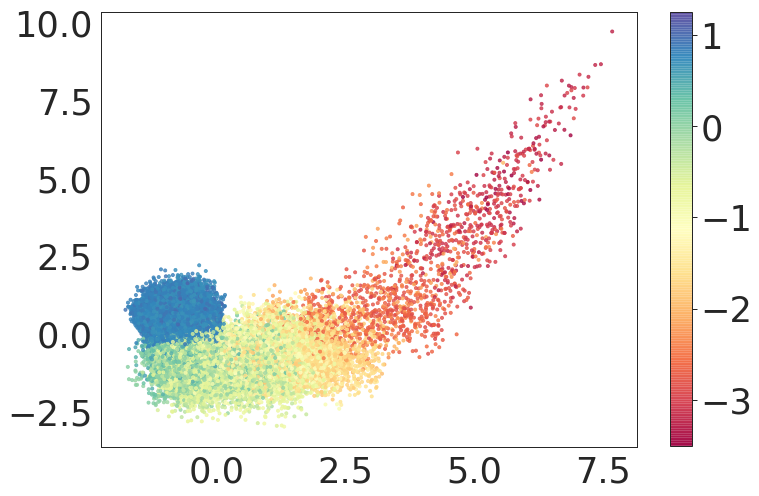

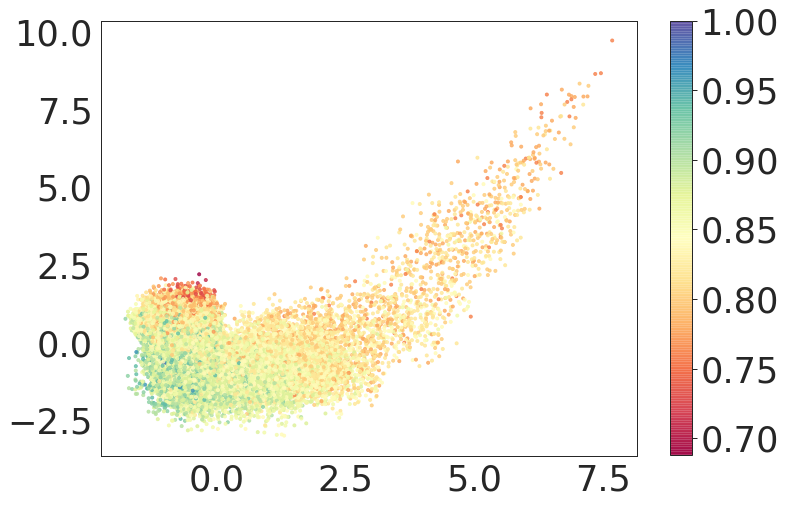

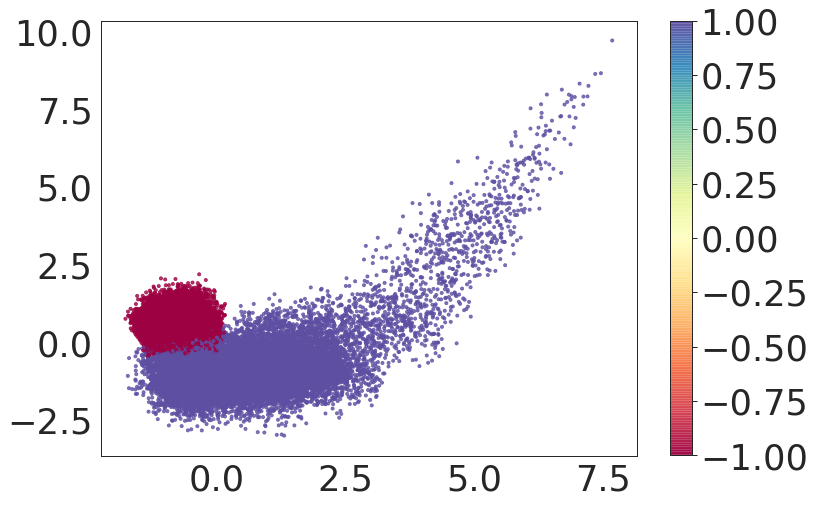

In [51]:
k=0
fs=30
props = ['strain', 'stress', 'density', 'orientation']
for prop in props: 
    pp = PdfPages('PCA-'+prop+'.pdf')
    sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 1.5})
    #sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.5})
    sns.set_style("white",{'axes.grid': False,'grid.linestyle': '--',  'axes.linewidth': 1.0,})
    #sns.set_style("white",{'axes.grid': True,'grid.linestyle': '--',  'axes.linewidth': 1.0,})

    #fig, axes =plt.subplots(2, 1, sharey='row')
    fig=plt.figure(figsize=(12, 8)) 


    if prop=='strain':
        plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_train_all[:, 0], cmap=plt.cm.Spectral, alpha=0.8, s=10)#
    elif prop=='stress':
        plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_train_all[:, 1], cmap=plt.cm.Spectral, alpha=0.8, s=10)
    elif prop=='density':
        plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=yy, cmap=plt.cm.Spectral, alpha=0.8, s=10)
    else:
        plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=yyy, cmap=plt.cm.Spectral, alpha=0.8, s=10)
    
    #plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_train_all[:, 1], cmap='viridis', alpha=0.8, s=2)#
    #plt.xlabel('PCA 1', fontsize=fs)
           #projected from 10D latent space')
    #plt.ylabel('PCA 2', fontsize=fs)
           #projected from 10D latent space')
#plt.xlim([7.5, 10])
    plt.colorbar()
    pngtext="PCA-"+prop+".png"
    plt.savefig(pngtext)
##plt.show()
    #if prop!='orientation':
    #plt.colorbar()
    pp.savefig(fig) 
    pp.close()

    #plt.colorbar()